## How to Find HLS Data by Tile: A Granule (MGRS) ID Search Tutorial


## Background
NASA’s Land Processes Distributed Active Archive Center (LP DAAC) archives and distributes Harmonized Landsat and Sentinel-2 (HLS) Version 2.0 products via its Cumulus cloud archive in the form of Cloud-Optimized GeoTIFFs (COGs).

The ```HLS_SuPER.py``` script is a command-line tool for spatial and temporal subsetting of HLS data. Users can specify regions of interest (ROI) using GeoJSON, Shapefiles, or bounding boxes, define time ranges, and select specific products and bands.

This notebook builds upon the existing ```HLS_SuPER.py``` script by introducing a feature that allows users to search for HLS data using a Military Grid Reference System (MGRS) tile ID, also referred to as a granule ID. While the ```earthaccess``` Python library provides an interface to query NASA's Common Metadata Repository (CMR), it currently lacks direct support for granule ID filtering.

This tutorial demonstrates how to implement a search-by-granule-ID feature using ```earthaccess```, which can support more targeted data discovery and enhance reproducibility in scientific research.




## Requirements
A NASA Earthdata Login account is required to download the data used in this tutorial. [Create an account here](https://urs.earthdata.nasa.gov/users/new).


## Learning Objectives
- Learn how to work with HLS Landsat (HLSL30.002) and Sentinel-2 (HLSS30.002) data products.
- Learn how to search for HLS granules using MGRS tile IDs via the CMR-STAC API and ```earthaccess```.


## Data Used
**HLSS30.002** – Daily 30 m global HLS Sentinel-2 MSI Surface Reflectance
- Derived from Sentinel-2A and 2B MultiSpectral Instrument (MSI) data
- Provides Nadir BRDF-Adjusted Reflectance (NBAR)

**HLSL30.002** – Daily 30 m global HLS Landsat-8 OLI Surface Reflectance
- Derived from Landsat-8 Operational Land Imager (OLI) data
- Provides Nadir BRDF-Adjusted Reflectance (NBAR)



## Tutorial Outline
<font color="blue">[1. Getting started](#1.-Getting-started)</font> 
- <font color="blue">[1.1. Python Environment and Packages](#1.1.-Python-Environment-and-Packages) </font> 
- <font color="blue">[1.2. EarthData Login](#1.2.-Earthdata-Login)</font> 
- <font color="blue">[1.3. Configure GDAL Options and rio environment](#1.3.-Configure-GDAL-Options-and-rio-environment)</font> 

<font color="blue">[2. CMR-STAC Search](#2.-CMR-STAC-Search)</font> 
- <font color="blue">[2.1 Why search by granule ID is a useful feature?](#2.1-Why-search-by-granule-ID-is-a-useful-feature?) </font>
- <font color="blue">[2.2 What are the challenges?](#2.2-What-are-the-challenges?) </font>
- <font color="blue">[2.3 What is the solution?](#2.3-What-is-the-solution?) </font>
-----------------------------------------------------------------------------------------------------------------------------------------

# 1. Getting started


## 1.1. Python Environment and Packages

To get started, make sure you have all the necessary Python packages installed. You can easily install them using the provided requirements.txt file. Simply open a terminal in the notebook's directory and run:


In [ ]:
pip install -r requirements.txt

This will ensure your environment has all the dependencies needed to run the notebook smoothly. If you're using a virtual environment, activate it first before running the command.

To begin using this notebook, make sure all necessary Python packages are imported. These libraries provide functions for accessing, processing, and visualizing HLS data. Run the following cell to import the required packages. If you encounter any ```ModuleNotFoundError```, ensure the package is installed by checking your environment or referring to the ```requirements.txt``` file.

In [2]:
%matplotlib inline

import os
from datetime import datetime
import numpy as np
import pandas as pd
import geopandas as gp
from skimage import io
import matplotlib.pyplot as plt
from osgeo import gdal
import xarray as xr
import rioxarray as rxr
import hvplot.xarray
import hvplot.pandas
import earthaccess
import pystac_client
import dask.distributed
import odc.stac
import xarray as xr
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import contextily
%run -i ./tools/plotting.ipynb
%run -i ./tools/data_access.ipynb
%run -i ./tools/ultilities.ipynb

## 1.2. Earthdata Login
We will use the ```earthaccess``` package for authentication. This <font color="blue">[tool](https://github.com/nsidc/earthaccess#readme)</font> can either create a new local ```.netrc``` file to securely store your NASA Earthdata credentials or validate an existing one in your user profile. If no ```.netrc``` file is found, you’ll be prompted to enter your credentials, and a file will be created for future use.

```earthaccess``` also manages token expiration automatically. It tracks expired credentials internally and refreshes them using stored <font color="blue">[refresh_tokens](https://earthaccess.readthedocs.io/en/latest/user-reference/auth/auth/#earthaccess.auth.Auth.refresh_tokens)</font>, so users do not need to manually handle <font color="blue">[temporal AWS credentials](https://nasa-openscapes.github.io/2021-Cloud-Hackathon/tutorials/05_Data_Access_Direct_S3.html)</font> or token renewals.

In [ ]:
earthaccess.login(persist=True)

## 1.3. Configure GDAL Options and rio environment

To ensure smooth handling of geospatial data, it’s important to configure GDAL options and the ```rasterio``` (```rio```) environment properly. GDAL options control how geospatial files are read, written, and processed, such as enabling Cloud Optimized GeoTIFF (COG) support or setting cache sizes.

In [6]:
# GDAL configurations used to successfully access LP DAAC Cloud Assets via vsicurl 
gdal.SetConfigOption('GDAL_HTTP_COOKIEFILE','~/cookies.txt')
gdal.SetConfigOption('GDAL_HTTP_COOKIEJAR', '~/cookies.txt')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','EMPTY_DIR')
gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS','TIF')
gdal.SetConfigOption('GDAL_HTTP_UNSAFESSL', 'YES')
gdal.SetConfigOption('GDAL_HTTP_MAX_RETRY', '10')
gdal.SetConfigOption('GDAL_HTTP_RETRY_DELAY', '0.5')
gdal.SetConfigOption('CPL_VSIL_CURL_USE_HEAD', 'FALSE')

# 2. CMR-STAC Search

To locate HLS data for a specific analysis, several key parameters need to be defined:

The following cell sets these important parameters:

* ```lat```: Central latitude of the area to analyze.
* ```lon```: Central longitude of the area to analyze.
* ```buffer```: The size of the square area (in degrees) around the central coordinates to include. For reasonable loading times, keep this value at 0.1 or less.
* ```start_year```: The starting year used as a baseline for analysis. 
* ```end_year```: The ending analysis year used for analyse. 

To illustrate challenges such as overlapping tiles in polar regions, this tutorial will focus on an area of interest (AOI) near the pole for the search.

In [5]:
# Define the analysis parameter for the analysis 
lat = 72.6
lon = -94
buffer_lat = 0.001
buffer_lon = 0.001
start_year = 2021
end_year = 2021

In [6]:
# Combine central lat,lon with buffer to get area of interest
lat_range = (lat - buffer_lat, lat + buffer_lat)
lon_range = (lon - buffer_lon, lon + buffer_lon)

The next cell will display the selected area on an interactive map. Feel free to zoom in and out to get a better understanding of the area you'll be analysing. Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.


In [6]:
display_map(lon_range, lat_range,centroid=[lat,lon])

To find HLS data, we will use the ```pystac_client``` Python library to query NASA’s Common Metadata Repository SpatioTemporal Asset Catalog (CMR-STAC). First, we define key search parameters including the collection name, date range, results limit, and bounding box. Using these parameters, we perform a STAC search via the LPCLOUD STAC endpoint and retrieve the results as a list of items.


## 2.1. Why search by tile ID is a useful feature?

To understand the usefulness of this feature, let’s examine an example that demonstrates the issue of overlapping HLS tiles covering the same point of interest on a single day.

In [7]:
%timeit
date_begin = '03-11'
date_end = '03-11'
item_list = search_cmr_stac(start_year,end_year,lat_range,lon_range,date_begin,date_end)

2021
Found 2 granules at point [-94.001, 72.59899999999999, -93.999, 72.601] from 2021-03-11 to 2021-03-11


As a result, a total of ***two*** S30 tiles were retrieved for ***one point*** on March 11, 2021.

Let’s take a closer look to understand why multiple tiles overlap over the same point by exploring the current shapefiles returned.


In [8]:
df_geo = pystac_to_json(item_list)
df_geo.crs = "epsg:4326"
len(np.unique(df_geo['mgrs_tile_id']))

2

There are in total **two** unique granule ID over this region. 
o visualize their geographic distribution, let’s examine them on the map.

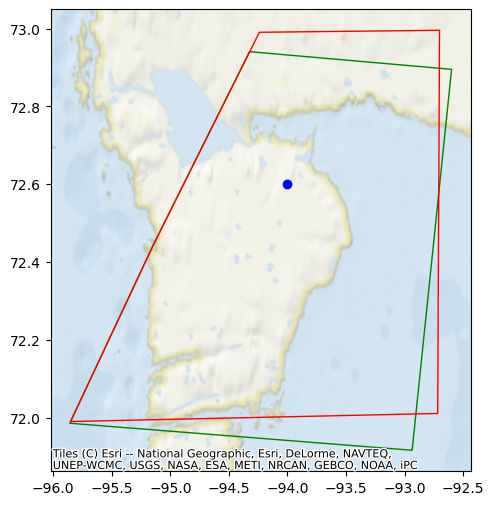

In [9]:
fig,ax=plt.subplots(figsize=(12,6))
colors = ['green','red']
i=0
for granule_id in np.unique(df_geo['mgrs_tile_id']):
    df_geo_loc = df_geo.loc[df_geo['mgrs_tile_id']==granule_id]
    df_geo_loc[["geometry"]].plot(facecolor="none",edgecolor=colors[i],ax=ax)
    i=i+1
ax.plot(lon,lat,'o',c='blue')
contextily.add_basemap(
    ax, crs = df_geo.crs, source=contextily.providers.Esri.NatGeoWorldMap, alpha=0.5
)

As we can see, two unique granules overlap at the same point—an issue that is especially common in polar regions.

If we are interested in only one specific granule (for example, the red tile), the current CMR-STAC search functionality does not provide a way to filter or select by granule ID.

In the next sections, I will explain in detail why CMR-STAC lacks this capability and how we can address this limitation.

## 2.2. What are the challenges? 

We cannot query the STAC API using keywords contained in the ```id``` field because the STAC API backend does **not** support substring searches on ```id```.

The LPCLOUD endpoint (```https://cmr.earthdata.nasa.gov/cloudstac/LPCLOUD```) is part of NASA’s Common Metadata Repository (CMR) STAC implementation. Currently, this API does not support the STAC API Filter Extension, specifically the Common Query Language 2 (CQL2), which provides advanced filtering capabilities such as substring matching on the ```id``` field.

## 2.3. What is the solution?

Until CMR-STAC updates its query language to support subsetting by ```id```, any client-side modifications will **not** change the search results.

Therefore, the only viable solution is to add a post-processing step that filters the returned ```items``` for relevant keywords after calling ```search.get_items()```. However, this approach still retrieves all results from the server without filtering by ```id```, so response times remain slow.

For example, if we want to search only for granules containing ```T14XPF```, we can pass this as a ```mgrs_tile_id``` parameter in the ```search_cmr_stac``` function and filter the results accordingly. The listing example contains two tile IDs: ```T14XPF``` and ```T15XVA```

In [10]:
np.unique(df_geo['mgrs_tile_id'])

array(['T14XPF', 'T15XVA'], dtype=object)

In [12]:
mgrs_tile_id = 'T14XPF'
date_begin='03-11'
date_end='03-11'
item_list_filter = search_cmr_stac(start_year,end_year,
                                   lat_range,lon_range,date_begin,date_end,
                                   mgrs_tile_id=mgrs_tile_id)

2021
Found 1 granules at point [-94.001, 72.59899999999999, -93.999, 72.601] from 2021-03-11 to 2021-03-11


As a result, after applying the filter function, the output contains only **1 granule** instead of 2, since we excluded the other tile ID.

Let’s check the map of the filtered results to verify.

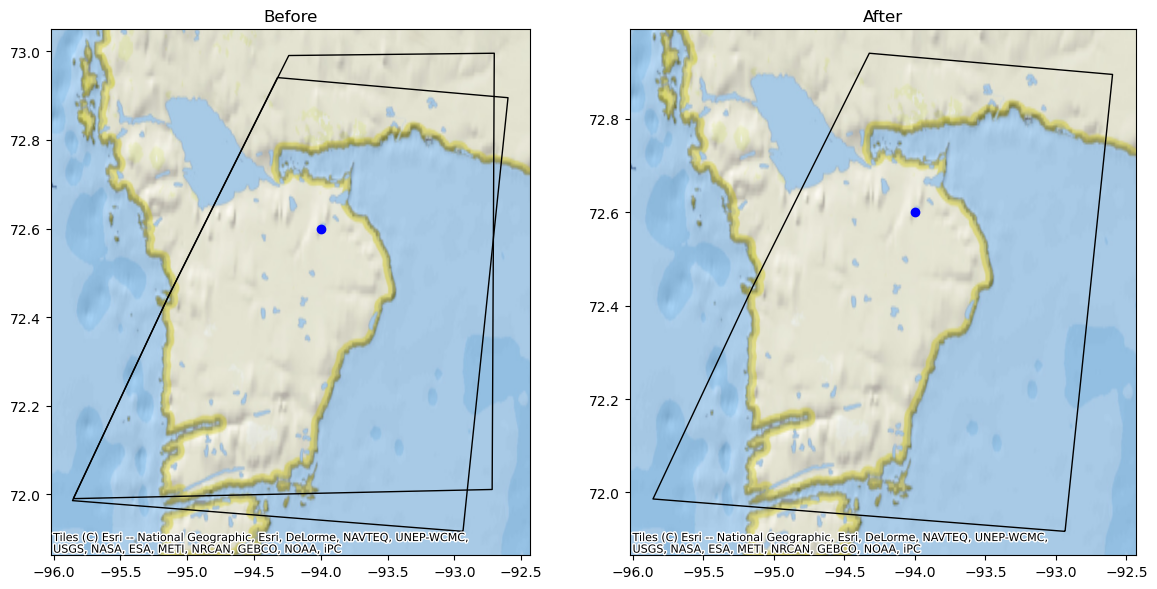

In [14]:
df_geo_filter = pystac_to_json(item_list_filter)
df_geo_filter.crs = "epsg:4326"
fig, axes = plt.subplots(figsize=(12,6),ncols=2,nrows=1)
df_list = [df_geo,df_geo_filter]
title_list = ['Before','After']
index=0
for ax in axes:
    df_list[index][["geometry"]].plot(facecolor="none",ax=ax)
    contextily.add_basemap(
    ax, crs=df_geo_filter.crs.to_string(), source=contextily.providers.Esri.NatGeoWorldMap)
    ax.plot(lon,lat,'o',c='blue')
    ax.set_title(title_list[index])
    index=index+1
plt.tight_layout()

## Conclusion

In this tutorial, we demonstrated how to effectively search and subset Harmonized Landsat Sentinel-2 (HLS) data by MRGS ID using Python tools and NASA’s CMR-STAC API. By implementing client-side filtering, we addressed limitations in the current API to enhance data selection accuracy, especially in complex regions such as the poles. We hope this guide helps streamline your workflow and supports your remote sensing research.

---

### **Acknowledgements**  
The Harmonized Landsat Sentinel-2 (HLS) solution is funded by NASA and was developed to address data needs identified by the U.S. Federal Government through the Satellite Needs Working Group (SNWG) biennial survey.



### **Contact Information**  
- **Author**: Trang Vo  
- **Contributors**: Madhu Sridhar, Chuck Daniels, Chris Holden, Sean Harkins  
- **Email**: tv0015@uah.edu  
- **Organization**: NASA MSFC IMPACT Project – HLS Production Team  
- **Last Modified**: July 3, 2025  



### **References**  
- <font color="blue">[HLS Product Information](https://www.earthdata.nasa.gov/data/projects/hls)</font>
- <font color="blue">[Getting Started with Cloud-Native HLS Data in Python](https://lpdaac.usgs.gov/resources/e-learning/getting-started-cloud-native-hls-data-python/)</font>
- <font color="blue">[Building an HLS-based EVI Time Series with ODC STAC](https://github.com/nasa/HLS-Data-Resources/blob/main/python/tutorials/EVI_timeseries_with_odc_stac.ipynb)</font>
